In [1]:
#maybe start looking neuron projection?
setwd(".../output")

In [2]:
library(rrvgo)
library(gprofiler2)
library(dplyr)
library(stringr)
library(org.Hs.eg.db) 
library(AnnotationDbi)
library(EnsDb.Hsapiens.v106)
library(tidyverse)
library(tibble)
library(data.table)
library(ggplot2)
library(pheatmap)




Warning message:
"package 'gprofiler2' was built under R version 4.2.3"
Warning message:
"package 'dplyr' was built under R version 4.2.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'stringr' was built under R version 4.2.3"
Loading required package: AnnotationDbi

Warning message:
"package 'AnnotationDbi' was built under R version 4.2.2"
Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, 

In [3]:
norm_counts<-read.table(".../0.Data/RNA_seq/counts_drugs_axion/voom_reads.txt")

In [4]:
edb <-EnsDb.Hsapiens.v106
ens<-rownames(norm_counts)
genes_ID=mapIds(edb, keys = ens, keytype="GENEID", column="GENENAME")
genes_ID=data.frame(genes_ID)
genes_ID$Geneid<-rownames(genes_ID)
colnames(genes_ID)<-c("Genename","Geneid")
norm_counts<-as.data.frame(norm_counts)
norm_counts$Geneid<-rownames(norm_counts)
norm_counts$Genename<-genes_ID$Genename[match(norm_counts$Geneid,genes_ID$Geneid)]

In [5]:
samples_info<-read.csv(".../0.Data/RNA_seq/samples_info.csv")
samples_info$group<-samples_info$group%>% str_replace("-", "_")
samples_info$sample<- samples_info$sample %>% str_replace("-", "_")


In [6]:
data<-read.csv(".../0.Data/Axion_MEA_data_processed/Well_summary_parameters_all_DIV30.csv")
data<-data[-1]
rownames(data)<-data$Unique_ID
order_Cell_line_general<-c('WTC','Mother_CNT','IPSI123',
                           'KdVS164','KdVS_CR',
                           'KdVS1','KdVS2','KdVS3')
data$Cell_line_general<-factor(data$Cell_line_general, levels=order_Cell_line_general)
data$batch_relabel <- factor(
  data$batch,
  levels = c('100-2031', '100-2016', 
              '118-2247',
               '129-7010', '129-7009', '129-7008', '129-7059'),       # old levels in new order
  labels = c("B22.1", "B22.2", 
             "B24.1",
             "B25.1","B25.2","B25.3","B25.4"))  # new names
data$annotation<-paste0(data$Compound_short,"_",
                                         data$batch_relabel,"_",
                                         data$Well_Label)
data$annotation_bp<-paste0(data$batch_relabel,"_",
                                         data$Well_Label)
#only rebutal
data_rebuttal<-data[data$batch_relabel %in% c("B25.1","B25.2","B25.3","B25.4"),]
data_rebuttal<-data_rebuttal[!data_rebuttal$annotation_bp %in% c("B25.3_A1","B25.4_E1","B25.4_E4"),] #weird WTC
data_rebuttal<-droplevels(data_rebuttal)
data_rebuttal<-data_rebuttal %>% 
    mutate(compound_v2 = case_when(Compound == "NT" ~ "NT",
    Compound == "phloretin" ~ "PH",
    Compound == "fasudil" ~ "F",
    TRUE ~ "Other")) # This is a catch-all for any other values
  # )) %>% 
  #   mutate(cell_line_v2 = case_when(Cell_line_general == "WTC" ~ "C1",
  #   Cell_line_general == "IPSI123" ~ "C4",
  #   Cell_line_general == "KdVS164" ~ "CR",
  #   Cell_line_general == "KdVS1" ~ "KdVS1",
  #   Cell_line_general == "KdVS2" ~ "KdVS2",
  #   Cell_line_general == "KdVS3" ~ "KdVS3",
  #   TRUE ~ "Other" # This is a catch-all for any other values
  # ))
data_rebuttal$sample<-paste0(data_rebuttal$Cell_line_general,"_",data_rebuttal$compound_v2,"_",data_rebuttal$Well_Label)
data_rebuttal<-data_rebuttal[data_rebuttal$batch %in% levels(factor(samples_info$MEA)),]
data_rebuttal<-data_rebuttal[data_rebuttal$sample %in% samples_info$sample,]
data_rebuttal<-droplevels(data_rebuttal)
rownames(data_rebuttal)<-data_rebuttal$sample

In [7]:

enrichment_result<-read.csv(".../0.Data/RNA_seq/All_modules_all_categories_enrichment_reduced_include_all_modules_split.csv")


In [8]:
enrichment_result_neuron_projection<-enrichment_result[enrichment_result$go == "GO:0043005",]
enrichment_result_neuron_projection<-split(enrichment_result_neuron_projection,enrichment_result_neuron_projection$module)
enrichment_result_neuron_projection<-lapply(enrichment_result_neuron_projection, function(df) {
  # Extract the 'intersection' column, collapse if multiple rows
  intersection_string <- paste(df$intersection, collapse = ",")
  
  # Split by comma and trim whitespace
  strsplit(intersection_string, ",\\s*")[[1]]
})
enrichment_result_neuron_projection<-lapply(enrichment_result_neuron_projection, function(vector) {
    #convert into df
    gene_df<-data.frame(Geneid = vector)
    result_df<- left_join(gene_df,  genes_ID, by = "Geneid")
  
  return(result_df)
})
#enrichment_result_neuron_projection

In [9]:
read_gmt_file <- function(file_path) {
  # Check if the file exists
  if (!file.exists(file_path)) {
    stop("File not found at specified path: ", file_path)
  }
  
  # Read the lines from the .gmt file
  gmt_lines <- readLines(file_path)
  
  # Create an empty list to store the gene sets
  gene_sets <- list()
  
  # Loop through each line of the file
  for (line in gmt_lines) {
    # Split the line by tab
    parts <- strsplit(line, "\t")[[1]]
    
    # The first element is the gene set ID
    go_id <- parts[1]
    
    # The remaining elements are the gene names (start from the 3rd column)
    genes <- parts[3:length(parts)]
    
    # Store the gene names in the list, using the ID as the name
    gene_sets[[go_id]] <- genes
  }
  
  return(gene_sets)
}


In [10]:
GO_CC<-read_gmt_file(".../0.Data/RNA_seq/hsapiens.GO_CC.name.gmt")

In [11]:
neruon_projection<-GO_CC[["GO:0043005"]]
length(neruon_projection)
#head(neruon_projection)

[1] 1394

In [12]:
all_non_intersecting_genes<-c()
for (comparison in names(enrichment_result_neuron_projection)){
  # Print the name of the gene set being checked
  print(comparison)
  
  # Get the data frame for the current gene set
  df <- enrichment_result_neuron_projection[[comparison]]
  
  # Extract the vector of gene names
  genes <- df$Genename
  
  # Check if all genes are in 'neruon_projection'
  if(all(genes %in% neruon_projection)){
    print("All genes in this set are in the neuron projection list.")
  } else {
    # Find the genes that are NOT in 'neruon_projection'
    non_intersecting_genes <- genes[!genes %in% neruon_projection]
    
    # Print the length of the non-intersecting genes
    print(paste("Problem: Found", length(non_intersecting_genes), "non-intersecting gene(s)."))
    
    # Print the names of the non-intersecting genes
    print("Non-intersecting gene names:")
    print(non_intersecting_genes)
    # Append the non-intersecting genes to the final vector
    all_non_intersecting_genes <- c(all_non_intersecting_genes, non_intersecting_genes)
  }
}
all_non_intersecting_genes<-unique(all_non_intersecting_genes)
#all_non_intersecting_genes

[1] "KdVS1_F_up"
[1] "Problem: Found 1 non-intersecting gene(s)."
[1] "Non-intersecting gene names:"
[1] "SYNE1"
[1] "KdVS1_PH_up"
[1] "All genes in this set are in the neuron projection list."
[1] "KdVS2_PH_up"
[1] "Problem: Found 4 non-intersecting gene(s)."
[1] "Non-intersecting gene names:"
[1] "CDHR3" "PRKCD" "SYT7"  "DLG3" 
[1] "KdVS3_PH_up"
[1] "All genes in this set are in the neuron projection list."


In [ ]:
neruon_projection<-c(neruon_projection,all_non_intersecting_genes)
#neruon_projection

In [13]:
#NB prop, EB prop, EB ISI, StdNIBI, NBR, MFR
activity_var<-c('Firing_rate_Hz','EB_prop','EB_ISI','NB_prop','NB_rate_Hz')#this has NA! 'INBI_Std',

In [14]:
norm_counts_np<-norm_counts[norm_counts$Genename %in% neruon_projection,]
norm_counts_np<- norm_counts_np %>% dplyr::select(where(is.numeric)) %>% t() %>% data.frame()
#head(norm_counts_np)

In [15]:
MEA_seq<-data_rebuttal %>% dplyr::select(where(is.numeric))
MEA_seq<-MEA_seq[,activity_var]
MEA_seq<-MEA_seq[rownames(norm_counts_np),]

In [16]:
DEGs_neuron_projection<-do.call(rbind,enrichment_result_neuron_projection)
DEGs_neuron_projection<-distinct(DEGs_neuron_projection)
DEGs_neuron_projection<-DEGs_neuron_projection$Genename


In [17]:
norm_counts_np<-norm_counts[norm_counts$Genename %in% DEGs_neuron_projection,]
norm_counts_np<- norm_counts_np %>% dplyr::select(where(is.numeric)) %>% t() %>% data.frame()
MEA_seq<-data_rebuttal %>% dplyr::select(where(is.numeric))
MEA_seq<-MEA_seq[,activity_var]
MEA_seq<-MEA_seq[rownames(norm_counts_np),]
#see how many sig corr, which are sig of neruon_projection. then, calculate mean expreesion and test corr!
#and select relevant activity variables not necesary all!
#1. neuron projection
# Define numbers of genes and samples 
nModules <- dim(norm_counts_np)[2]
nMetrics <- dim(MEA_seq)[2]
#module.trait.corr <- cor(module_eigengenes, mea_traits_noMeta, use = 'p')#first see spearman, which is more "strict". No significant
module.trait.corr <- WGCNA::cor(norm_counts_np, MEA_seq, method = 'spearman')

In [18]:
# nModules
# nMetrics
#sapply(seq.int(dim(module_eigengenes)[1]), function(i) cor.test(module_eigengenes[i,], clusters_only[i,], method = 'spearman'))
est_list<-list()
pval_list<-list()
for (i in 1:nMetrics){
    est <- c()
    p <- c()
    for (j in 1:nModules){
    s_corr<-cor.test(MEA_seq[[i]],norm_counts_np[[j]],method = 'spearman',exact = FALSE)
    p_val<-s_corr$p.value
    estimate<-unname(s_corr$estimate)
     est[j]<- estimate  
     p[j]<- p_val  
    }
    est_list[[i]]<-est
    pval_list[[i]]<-p
    }
names(est_list)<-colnames(MEA_seq)
names(pval_list)<-colnames(MEA_seq)
est_list<-do.call(cbind,est_list)
pval_list<-do.call(cbind,pval_list)
rownames(est_list)<-colnames(norm_counts_np)
rownames(pval_list)<-colnames(norm_counts_np)
all_adj<-round(p.adjust(c(pval_list), method ="fdr", n = length(c(pval_list))),3)
all_adj<-split(all_adj,ceiling(seq_along(all_adj) / nModules))
all_adj<-as.data.frame(t(do.call(rbind, all_adj)))
rownames(all_adj)<-rownames(pval_list)
colnames(all_adj)<-colnames(pval_list)
all_adj<-as.matrix(all_adj)

module.trait.corr.pvals<-all_adj#all_adj#pval_list
module.trait.corr<-est_list
modules<-rownames(module.trait.corr)
module.trait.corr_m<-as.data.frame(melt(module.trait.corr))
module.trait.corr.pvals_m<-as.data.frame(melt(module.trait.corr.pvals))
colnames(module.trait.corr_m)<-c("Geneid", "trait", "corr")
colnames(module.trait.corr.pvals_m)<-c("Geneid", "trait", "pvalue")
module.trait.corr.pvals_m$pvalue<-round(module.trait.corr.pvals_m$pvalue,2)
module.trait.corr_m$Genename<-genes_ID$Genename[match(module.trait.corr_m$Geneid,genes_ID$Geneid)]
module.trait.corr.pvals_m$Genename<-genes_ID$Genename[match(module.trait.corr.pvals_m$Geneid,genes_ID$Geneid)]

significant_modules_corr_m<-unique(module.trait.corr.pvals_m[module.trait.corr.pvals_m$pvalue <= 0.05,"Genename"])
significant_modules_corr_m_id<-unique(module.trait.corr.pvals_m[module.trait.corr.pvals_m$pvalue <= 0.05,"Geneid"])

Warning message in melt(module.trait.corr):
"The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(module.trait.corr). In the next version, this warning will become an error."
Warning message in melt(module.trait.corr.pvals):
"The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(module.trait.corr.pvals). In the next version, this warning will become an error."


In [19]:



#add corr th
corr_th<-0.5
significant_modules_corr_m_corr<-unique(module.trait.corr_m[abs(module.trait.corr_m$corr) >= corr_th,"Genename"])
significant_modules_corr_m_id_corr<-unique(module.trait.corr_m[abs(module.trait.corr_m$corr) >= corr_th,"Geneid"])

significant_modules_corr_m<-intersect(significant_modules_corr_m,significant_modules_corr_m_corr)
significant_modules_corr_m_id<-intersect(significant_modules_corr_m_id,significant_modules_corr_m_id_corr)

significant_metric<-unique(module.trait.corr.pvals_m[module.trait.corr.pvals_m$pvalue <= 0.05,"trait"])


significant_metric<-droplevels(significant_metric)
module.trait.corr_m_sig<-module.trait.corr_m[module.trait.corr_m$Genename %in% significant_modules_corr_m,]
module.trait.corr_m_sig<-droplevels(module.trait.corr_m_sig)

module.trait.corr.pvals_m_sig<-module.trait.corr.pvals_m[module.trait.corr.pvals_m$Genename %in% significant_modules_corr_m,]
module.trait.corr.pvals_m_sig<-droplevels(module.trait.corr.pvals_m_sig)

#organize de heatmap based on hier clustering
# Cluster based on euclidean distance

clust_metrics <- hclust(dist(t(module.trait.corr[significant_modules_corr_m_id,])))
clust_modules<-hclust(dist(module.trait.corr[significant_modules_corr_m_id,]))

# Get the ordered names from clustering
ordered_genes <- rownames(module.trait.corr)[clust_modules$order]
ordered_traits <- colnames(module.trait.corr)[clust_metrics$order]
#ordered_genes
module.trait.corr_m_sig$Geneid <- factor(
  module.trait.corr_m_sig$Geneid,
  levels = ordered_genes
)

module.trait.corr_m_sig$trait <- factor(
  module.trait.corr_m_sig$trait,
  levels = ordered_traits
)

# Now apply the same factor levels to the p-value data frame
module.trait.corr.pvals_m_sig$Geneid <- factor(
  module.trait.corr.pvals_m_sig$Geneid,
  levels = ordered_genes
)

module.trait.corr.pvals_m_sig$trait <- factor(
  module.trait.corr.pvals_m_sig$trait,
  levels = ordered_traits
)

# Create a mapping from ordered Geneid to Genename
ordered_genenames <- genes_ID$Genename[match(ordered_genes, genes_ID$Geneid)]

# --- 3. REORDER THE DATA FRAME FOR PLOTTING ---
# Convert the Genename and trait columns to factors and set their levels
# based on the clustering order.
module.trait.corr_m_sig$Genename <- factor(
  module.trait.corr_m_sig$Genename,
  levels = ordered_genenames
)

module.trait.corr_m_sig$trait <- factor(
  module.trait.corr_m_sig$trait,
  levels = ordered_traits
)

# Apply the same factor levels to the p-value data frame
module.trait.corr.pvals_m_sig$Genename <- factor(
  module.trait.corr.pvals_m_sig$Genename,
  levels = ordered_genenames
)

module.trait.corr.pvals_m_sig$trait <- factor(
  module.trait.corr.pvals_m_sig$trait,
  levels = ordered_traits
)


In [20]:
to_plot<-module.trait.corr[significant_modules_corr_m_id,]
to_plot

,Firing_rate_Hz,EB_prop,EB_ISI,NB_prop,NB_rate_Hz
ENSG00000143858,0.5444015,0.51788932,-0.379922780,0.4797941,0.27639463
ENSG00000143786,0.4185328,0.57657658,-0.624453024,0.3750322,0.06074465
ENSG00000162545,0.6383526,0.71042471,-0.599485199,0.6133848,0.34128391
ENSG00000121905,-0.4803089,-0.28880309,0.108880309,-0.5583012,-0.53685837
ENSG00000184144,-0.5129987,-0.23526384,0.005662806,-0.3889318,-0.59578975
ENSG00000186094,-0.5794080,-0.28185328,0.004633205,-0.5577864,-0.68748956
ENSG00000187961,0.4321750,0.21750322,0.210810811,0.6620335,0.69487217
ENSG00000163630,-0.6254826,-0.39485199,0.159073359,-0.4337194,-0.57286479
ENSG00000163932,-0.4350064,-0.45405405,0.527927928,-0.1276705,-0.03898537
ENSG00000169760,0.4316602,0.66048906,-0.748262548,0.1093951,-0.11656756


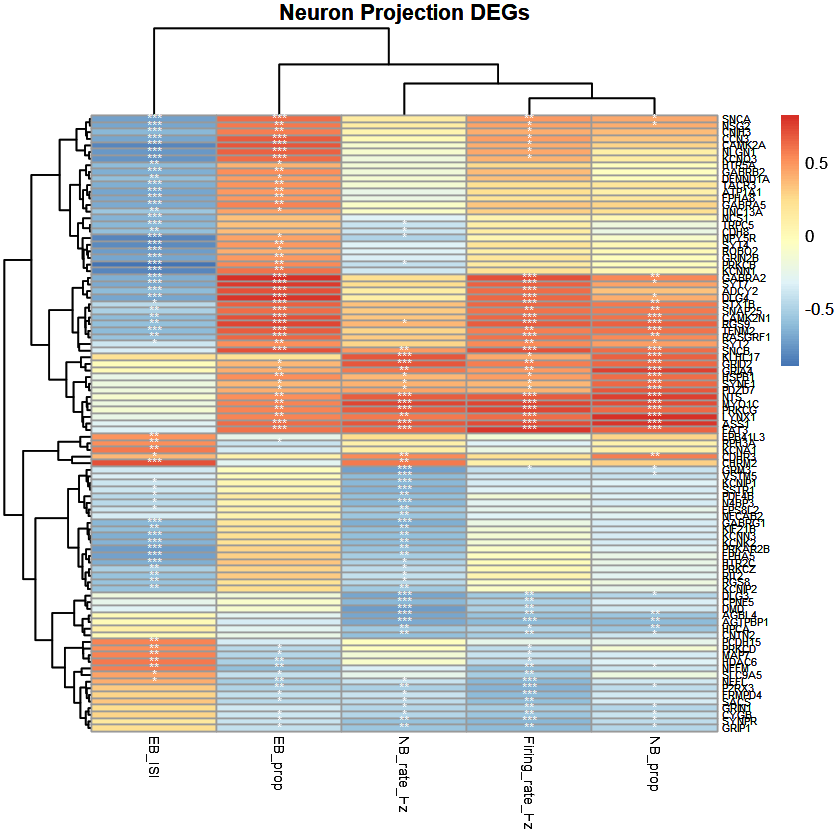

In [21]:
# Prepare matrices with gene names
corr_matrix <- module.trait.corr[significant_modules_corr_m_id, ]
pval_matrix <- module.trait.corr.pvals[significant_modules_corr_m_id, ]

# Replace row names with gene names
rownames(corr_matrix) <- genes_ID$Genename[match(rownames(corr_matrix), genes_ID$Geneid)]
rownames(pval_matrix) <- genes_ID$Genename[match(rownames(pval_matrix), genes_ID$Geneid)]

# Create asterisk matrix
asterisk_matrix <- matrix("", nrow = nrow(pval_matrix), ncol = ncol(pval_matrix))
asterisk_matrix[pval_matrix < 0.05] <- "*"
asterisk_matrix[pval_matrix < 0.01] <- "**"
asterisk_matrix[pval_matrix < 0.001] <- "***"

# Create heatmap
p<-pheatmap(corr_matrix,
         display_numbers = asterisk_matrix,
         number_color = "white",
         fontsize_number = 8,
         fontsize_row = 6,      # Gene name font size
         fontsize_col = 8,      # Trait name font size
         show_rownames = TRUE,
         main = "Neuron Projection DEGs")
p
ggsave("pheatmap_neuron_projection_cc_DEGs_corr05.pdf",
       width= 4,
       height = 8,
       plot=p)